------------Streak Trajectories-------------------

Aim of this code is to simulate the streaks using an experimental set of z-stacks which gives the diameter variation of the moving particle as it varies in 'z' /axial direction. 
This allows to test various hypotheses relating the image formation in the sensor for long exposure times as well as to develop and test methods to extract streak information.

In [15]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pims
import skimage.measure
import pylab
from skimage.filters import difference_of_gaussians, window, gaussian
from scipy.optimize import curve_fit
from PIL import Image
import radial_functions as fun

import cv2


In [16]:
#useless functions defined here :
frames =[]
#Get the center coordinates from the function in "radial_functions.py"
def Get_Center(frameStart, frameEnd, plott):

    img = frames[frameStart:frameEnd]
    contour = fun.see_all_contours(img,100)
    xpos = np.asarray(contour['x'])
    ypos = np.asarray(contour['y'])
    radius = np.asarray(contour['radius'])[:]

    #Plot to see the image
    #call to plot_frame
    if plott==True:
        plot_frame(frames[frameStart],xpos,ypos,radius)

    return (xpos, ypos)



#plot contour inside frame
def plot_frame(frame,xpos,ypos,radius):
        
    fig, ax = plt.subplots()
    ax.imshow(frame,  cmap="Greys_r")
    ax.plot(xpos,ypos, 'r+', linewidth='2')
    circle1 = plt.Circle((xpos, ypos),radius,color='r', fill=False, linewidth=0.5)
    ax.add_patch(circle1)

    fig.canvas.draw()
    plt.show()

    return 




In [17]:
#Initialize the grid/coordinate space for the trajectories
Grid = np.zeros((600,750))
Grid[:,350]= 255; Grid[300,:]=255
#display the array as an image using imshow, showing the center of the image


In [18]:
#Read a test image to be places on the start of trajectory
@pims.pipeline
def conv_gray(frame):
    one_channel = frame[:,:,1]
    return one_channel

#Change path to the image set in the line below
#frames =(pims.open('*.tif'))
frames =(pims.open('*.tif'))
img = frames[0:116]
#rescale image here
dim = 350

#img = Image.open('')


In [19]:
#Input Flow velocity parameters which define the pixel distance between successive frame placements
vx = 1 # in mm/s , simulating a streak at the center of the channel (max flow velocity)
Resolution = 162.5 # in nm/pixel; corresponds to an NA of 20x objective
Exposure = 60 # in ms, this is a parameter we control
zstack_length = img._len # no. of frames in the calibration stack

streak_length = (vx * Exposure * 1000)/162.5 # streak length in pixels
sample_distance = streak_length/zstack_length

#To obtain a smoother streak, will place the same frame consecutively approx. 2 times 
sd = sample_distance/2

In [20]:
#Morphology cv filtering

def morphimage(img,showplot):
    #stretch the dynamic range
    stretch = skimage.exposure.rescale_intensity(img, in_range='image',out_range=(0,255))
    

    #morph
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (100,100))
    morph = cv2.morphologyEx(stretch,cv2.MORPH_CLOSE, kernel)
    kernel = cv2.getStructuringElement( cv2.MORPH_ELLIPSE, (200,200))
    morph = cv2.morphologyEx(morph, cv2.MORPH_OPEN, kernel)

    #grayscale
    grey = morph.astype("uint8")

    #threshold
    thresh = cv2.threshold(grey, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]

    #largest contour
    contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    bigcontour = max(contours, key = cv2.contourArea)

    #draw on black background
    contour = np.zeros((stretch.shape[:2]),dtype=np.uint8)
    result = np.zeros_like(stretch)
    cv2.drawContours(contour, [bigcontour], 0, 255,-1)
    result[contour>0] = stretch[contour>0]
    if showplot==True:
        plt.imshow(result)
      
    return result, thresh

#morphimage(img[31],True)


In [21]:
required = 15 # frame numnber for required iintensity profile
profile =[]; saved_scenterx=[]; saved_scentery=[]; saved_frame=[];

for i, frame in enumerate(img):
    img2 = Image.fromarray(frame)
    width, height = img2.size
    n_img = img2.resize((dim,dim))

    centerx, centery = Get_Center(15,15 + 1,False); # see how the contour fits to the raw image #THIS IS TO JUST GET THE CENTERLINE COORDS; NO NEED TO ENUMERATE 
    #plt.imshow(img)

    #place the de-scaled images progressively along the path in the Grid
    n_img = np.asarray(n_img)

    #morphed_img, thresh = morphimage(n_img,False)
    morphed_img = n_img

    #recalculate center for scled images
    #if i==0 :
    scenterx = (centerx[0]/width)*dim
    scentery = (centery[0]/height)*dim

    scenterx = scenterx.astype(int)
    scentery = scentery.astype(int)

    #if i == required:
    profile = morphed_img[scenterx,:] # save the intensity profile for latter comparison
    #plt.imshow(morphed_img)
    saved_scenterx.append(scenterx)
    saved_scentery.append(scentery)
    saved_frame.append(morphed_img)

    vector = np.vectorize(np.int_)
    Grid[(int((Grid.shape[0]/2))-(scenterx)):(int((Grid.shape[0]/2))+(dim-scenterx)),(550-scentery-int((i)*sample_distance)):(550-scentery+dim-int((i)*sample_distance))] += vector(morphed_img)

...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
...processing image 0 of 1
.

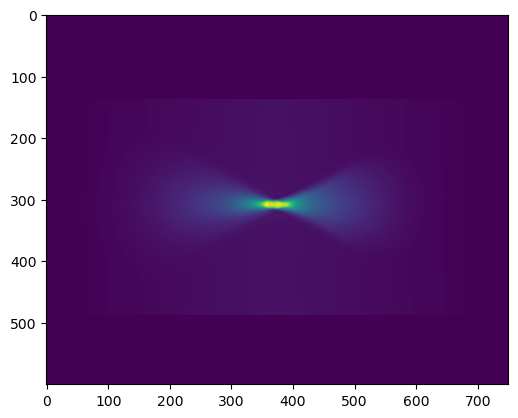

In [22]:

#Grid[(300-scenterx[0]):(300+dim-scenterx[0]),(400-scentery[0]):(400-scentery[0]+dim)] += n_img
plt.imshow(Grid, interpolation='sinc')


In [23]:
#Give an image interpolation to smoothen out the frames

#bilinear_img = cv2.resize(Grid,None,fx=2,fy=2,interpolation=cv2.INTER_CUBIC)
#kernel = np.ones((4,4),np.float32)/16
#convolved = cv2.filter2D(bilinear_img,-1,kernel)
#plt.imshow(convolved)

radius of extracted profile: 27.221237751286225 um
radius of original profile: 24.463880963267613 um
Percentage difference 11.27113393070694 %


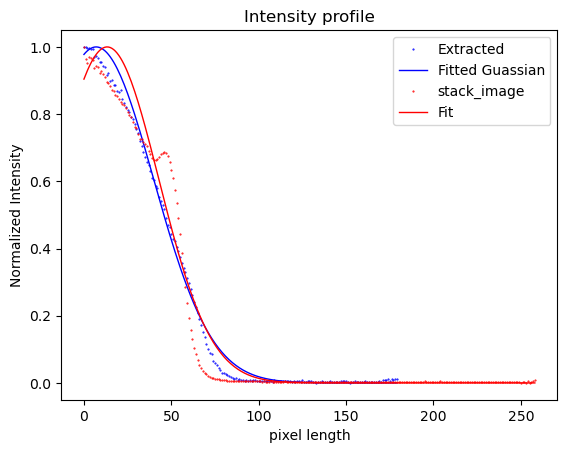

<Figure size 640x480 with 0 Axes>

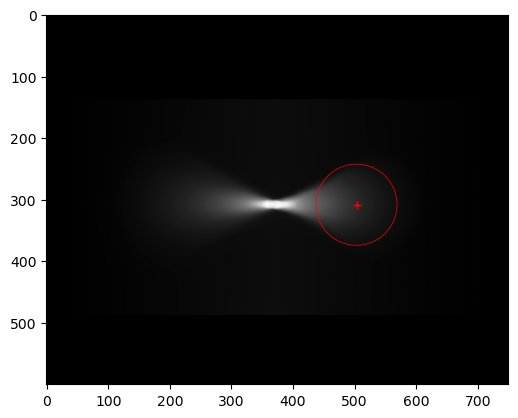

In [24]:
#compare the intesnity profile at a specific z-height/ frame before and after motion blur

compared = Grid[int(Grid.shape[0]/2) - saved_scenterx[required]: int(Grid.shape[0]/2) + (dim-saved_scenterx[required]), 550 - int(required*sample_distance)]
#compared = compared/ (np.max(compared))
#profile = profile/ np.max(profile[0])


# Radius is determined by full width at half maximum
radius_compared, newx, level, mean= fun.radius_usingprofile(compared, saved_scenterx[required]+8) # +8 is the problem!
radius_profile, newx2, level2, mean2= fun.radius_usingprofile2D(saved_frame[required],[saved_scenterx[required],saved_scentery[required]])
#radius_profile, newx2, level2= fun.radius_usingprofile(profile[0]) # NOTEEEE --- THERE IS A BACKGROUND SUBSTRACTION HERE !!!!!!!!!!!!!!!!!!!!!

radius_compared_um = (radius_compared/dim)*height *Resolution/1000
radius_profile_um = (radius_profile/dim)*height * Resolution/1000
print('radius of extracted profile:' , radius_compared_um,'um')
print('radius of original profile:', radius_profile_um , 'um')
print('Percentage difference', abs(radius_compared_um-radius_profile_um)*100/(radius_profile_um), '%')

#plot em together
xpx = np.linspace(0,len(newx)-1, len(newx))

xpx2 = np.linspace(0,len(newx2)-1, len(newx2))

plt.figure()
plt.plot(xpx, newx, 'b.', markersize=1, linewidth=1)

#fit gaussian and plot
plt.plot(xpx, fun.gauss(xpx, 1, mean, level),'b-',linewidth=1)
plt.plot( xpx2, newx2,'r.', markersize=1, linewidth=1)
#fit gauss
plt.plot(xpx2, fun.gauss(xpx2, 1, mean2, level2),'r-' ,markersize=1, linewidth=1)
plt.title('Intensity profile')
plt.ylabel('Normalized Intensity')
plt.xlabel('pixel length');
plt.legend(['Extracted','Fitted Guassian','stack_image','Fit'])

plt.figure()
#plt.imshow(Grid)
plot_frame(Grid,550 - int(required*sample_distance), int(Grid.shape[0]/2)+8 ,radius_compared)
#plt.figure()
#plot_frame(saved_frame,saved_scenterx, saved_scentery ,radius_profile)


THE FOLLOWING IS TO CHECK WHETHER THE ORIGINAL INTENSITY DISTRIBUTION ACROSS THE CENTER IS PRESERVED WHEN THE STREAK IMAGE IS
FORMED IN THE CCD SENSOR IN THE CAMERA. THE TIME INTERGRATION WILL CONVOLUTE THE INTENISTY VARIATION OF ONE FRAME WITH THE INTENSITY VARIATIONS OF SUCCESSIVE FRAMES.

COMPARISON AGAINST A CALIBRATION DATA SET IS DEPENDENT UPOUN HOW CLOSELY THE INTENSITY VARIATION EXTRACTED FROM THE STREAK RESEMBLES WITH THE THE ORIGINAL UN-CONVOLUTED SINGLE Z-STACK FRAMES.

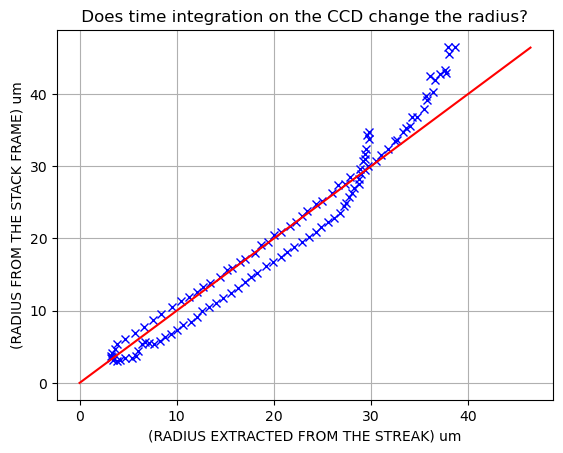

In [25]:
#PLOT A GRAPH OF (RADIUS FROM THE STACK FRAME) VS. (RADIUS EXTRACTED FROM THE STREAK)
# AT SAME INTERVALS THE FRAMES ARE PLACED
radius_compared_um=[]; radius_profile_um=[]; radius_stored_forplot=[];
for i in range(frames.shape[0]-1):

    try:
        compared = Grid[int(Grid.shape[0]/2) - saved_scenterx[i]: int(Grid.shape[0]/2) + (dim-saved_scenterx[i]), 550 - int(i*sample_distance)]

        # Radius is determined by full width at half maximum
        radius_compared, newx, level, mean= fun.radius_usingprofile(compared, saved_scenterx[i]+8) # +8 is the problem!
        radius_profile, newx2, level2, mean2= fun.radius_usingprofile2D(saved_frame[i],[saved_scenterx[i],saved_scentery[i]])
        #radius_profile, newx2, level2= fun.radius_usingprofile(profile[0]) # NOTEEEE --- THERE IS A BACKGROUND SUBSTRACTION HERE !!!!!!!!!!!!!!!!!!!!!

        radius_compared_um.append((radius_compared/dim)*height *Resolution/1000)
        radius_profile_um.append((radius_profile/dim)*height * Resolution/1000)
        radius_stored_forplot.append(radius_compared)

    except:
        radius_compared_um.append(0)
        radius_profile_um.append(0)
        radius_stored_forplot.append(0)

#plot this
    
plt.figure()
plt.plot(radius_compared_um,radius_profile_um,'bx')
plt.plot(np.linspace(0,len(radius_compared_um)*0.4,500),np.linspace(0,len(radius_compared_um)*0.4,500),'r-')
plt.title(' Does time integration on the CCD change the radius? ')
plt.ylabel('(RADIUS FROM THE STACK FRAME) um')
plt.xlabel('(RADIUS EXTRACTED FROM THE STREAK) um')
plt.grid()

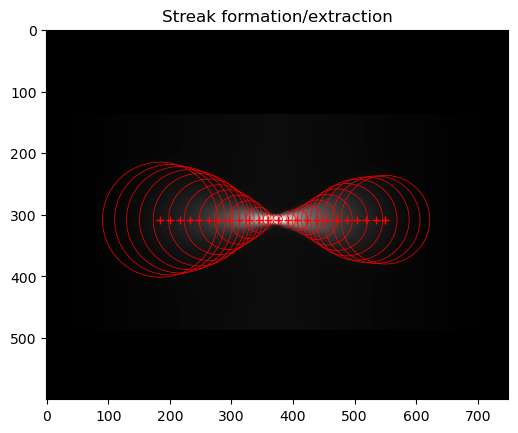

In [26]:

fig, ax = plt.subplots()

for i in range(frames.shape[0]-1):
    if(i%5==0):
        xpos = 550 - int(i*sample_distance)
        ypos =  int(Grid.shape[0]/2)+8 
        radius = radius_stored_forplot[i]
        ax.plot(xpos,ypos, 'r+', linewidth='1')
        circle1 = plt.Circle((xpos, ypos),radius,color='r', fill=False, linewidth=0.5)
        ax.add_patch(circle1)

plt.title('Streak formation/extraction')
ax.imshow(Grid,  cmap="Greys_r")
fig.canvas.draw()
plt.show()


Fit a hyperbolic(linearized) to the diameters extracted from the streak, to determine Vz by fitting parameters.
Ideally we need a calibration fit but try to estimate from the objective parameters themselves.

Streak length in time is just the Exposure time
0 -> tau

Time interval between z-stack centers =  exposure/zlength

In [27]:
xx= np.linspace(0,Exposure,len(radius_compared_um))-np.argmin(radius_compared_um)*(Exposure/zstack_length)

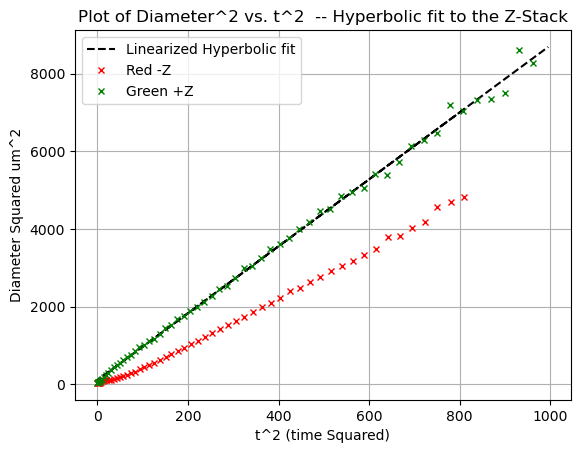

In [28]:
#fit a hyperbolic function to the above diameter vs height variation
plt.figure()
dii_squared = np.multiply(radius_profile_um,radius_profile_um)*4
frame_sqrd = np.multiply(xx, xx)
pred_params, uncert_cov = curve_fit(fun.line,frame_sqrd[np.argmin(radius_compared_um):-1],dii_squared[np.argmin(radius_compared_um):-1], method='lm')
x = np.linspace(0,Exposure,1000)-np.argmin(radius_compared_um)*(Exposure/zstack_length)
yy = (pred_params[1] + pred_params[0]* np.multiply(x,x))
plt.plot(np.multiply(x,x), yy, ls='--',c='k')
plt.plot(frame_sqrd[0:np.argmin(radius_compared_um)],dii_squared[0:np.argmin(radius_compared_um)], 'rx',markersize=5)
plt.plot(frame_sqrd[np.argmin(radius_compared_um):-1],dii_squared[np.argmin(radius_compared_um):-1], 'gx',markersize=5)

plt.grid()
plt.xlabel('t^2 (time Squared)')
plt.ylabel('Diameter Squared um^2')
plt.title('Plot of Diameter^2 vs. t^2  -- Hyperbolic fit to the Z-Stack')
plt.legend(['Linearized Hyperbolic fit','Red -Z', 'Green +Z'])